In this module we will focus on Gradient Based Learning. We will start with learning conditional distributions with maximum likelihood.

What is conditional statistic? 
Conditional Statistic means we don't model the whole distribution, we focus on a statisctic of it. Mean -> Regression, class prob -> Classification. For MSE it will become (mean - prediction of mean)^2

In [5]:
### Now we will implement gradient-Based learning for binary classification with maximum likelihood (Conditional distribution)
import numpy as np
import matplotlib.pyplot as plt

Epoch 1/1000, Loss: 3.2418
Epoch 101/1000, Loss: 1.3471
Epoch 201/1000, Loss: 0.3209
Epoch 301/1000, Loss: 0.3157
Epoch 401/1000, Loss: 0.4709
Epoch 501/1000, Loss: 0.6401
Epoch 601/1000, Loss: 0.6510
Epoch 701/1000, Loss: 1.0042
Epoch 801/1000, Loss: 1.6744
Epoch 901/1000, Loss: 0.5953
Epoch 1/1000, Loss: 2.7723
Epoch 101/1000, Loss: 0.3569
Epoch 201/1000, Loss: 0.4526
Epoch 301/1000, Loss: 0.5890
Epoch 401/1000, Loss: 0.2519
Epoch 501/1000, Loss: 0.4640
Epoch 601/1000, Loss: 0.7424
Epoch 701/1000, Loss: 0.3396
Epoch 801/1000, Loss: 0.2538
Epoch 901/1000, Loss: 0.3333
Epoch 1/1000, Loss: 1.6788
Epoch 101/1000, Loss: 0.1352
Epoch 201/1000, Loss: 0.0995
Epoch 301/1000, Loss: 0.0856
Epoch 401/1000, Loss: 0.1094
Epoch 501/1000, Loss: 0.1146
Epoch 601/1000, Loss: 0.0852
Epoch 701/1000, Loss: 0.0959
Epoch 801/1000, Loss: 0.1403
Epoch 901/1000, Loss: 0.0727
Epoch 1/1000, Loss: 14.0518
Epoch 101/1000, Loss: 5880.1295
Epoch 201/1000, Loss: 6477.2459
Epoch 301/1000, Loss: 16447.2513
Epoch 401/1

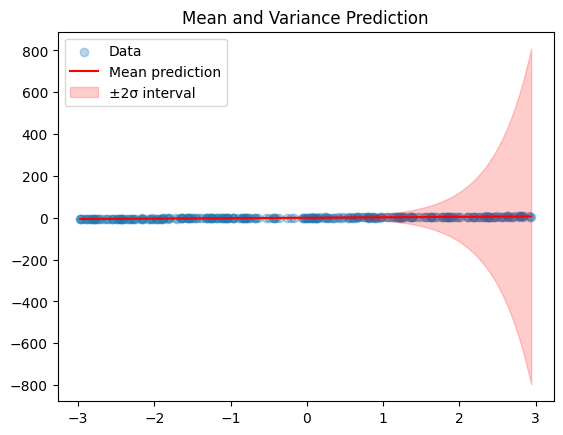

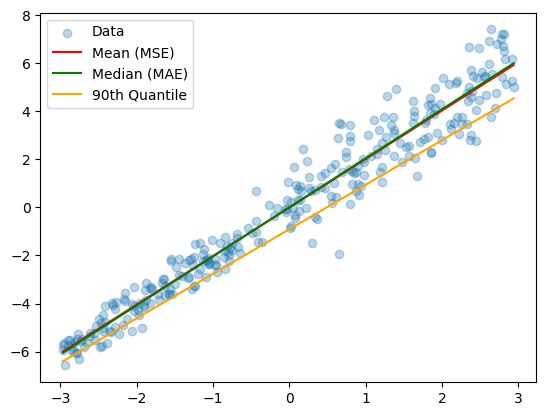

In [14]:
class ConditionalLinearModel():
    def __init__ (self, n_features, mode="mean", tau = 0.5):
        """
        mode: "mean", "median", "variance"
        tau: for quantile regression
        """
        self.mode = mode
        self.tau = tau
        if mode == "mean_var":
            self.W = np.random.randn(n_features, 2) * 0.01
            self.b = np.zeros((1,2))
        else:
            self.W = np.random.randn(n_features, 1) * 0.01
            self.b = np.zeros((1,1))
        
    def forward(self, X):
        return X @ self.W + self.b
    
    def loss_and_grads(self, X, y):
        n_samples = X.shape[0]
        y_pred = self.forward(X)
        
        if self.mode == "mean":
            loss = np.mean((y_pred - y) ** 2)
            dL_dy_pred = 2 * (y_pred - y) / n_samples
        elif self.mode == "median":
            loss = np.median(np.abs(y_pred - y))
            dL_dy_pred = np.sign(y_pred - y) / n_samples
        elif self.mode == "quantile":
            diff = y_pred - y
            loss = np.mean(np.maximum(self.tau * diff, (self.tau - 1) * diff))
            dL_dy_pred = np.where(diff > 0, self.tau, self.tau - 1) / n_samples
        elif self.mode == "mean_var":
            mean_pred = y_pred[:, 0:1]
            var_pred = np.exp(y_pred[:, 1:2])
            loss = np.mean((y - mean_pred) ** 2) + np.mean((y - var_pred) ** 2)
            dL_dy_pred = np.zeros_like(y_pred)
            dL_dy_pred[:, 0:1] = 2 * (y_pred[:, 0:1] - y) / n_samples
            dL_dy_pred[:, 1:2] = 2 * (y_pred[:, 1:2] - y) / n_samples
        
        return loss, dL_dy_pred

    def fit(self, X, y, learning_rate=0.01, n_epochs=1000, batch_size=32):
        n_samples = X.shape[0]
        loss_history = []
        
        for epoch in range(n_epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            
            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                
                loss, dL_dy_pred = self.loss_and_grads(X_batch, y_batch)
                loss_history.append(loss)
                
                dL_dW = X_batch.T @ dL_dy_pred
                dL_db = np.sum(dL_dy_pred, axis=0, keepdims=True)
                
                self.W -= learning_rate * dL_dW
                self.b -= learning_rate * dL_db
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}")
        
        return loss_history

    def predict(self, X):
        y_pred = self.forward(X)
        if self.mode == "mean":
            return y_pred
        elif self.mode == "median":
            return y_pred
        elif self.mode == "quantile":
            return y_pred
        elif self.mode == "mean_var":
            mean_pred = y_pred[:, 0:1]
            var_pred = np.exp(y_pred[:, 1:2])
            return mean_pred, var_pred
            

np.random.seed(42)
m, n = 300, 1
X = np.random.uniform(-3, 3, (m, n))
true_mu = 2 * X ### True mean
true_sigma = 0.5 + 0.5 * (X > 0) ### True variance
y = true_mu + true_sigma * np.random.randn(m, 1)

mean_model = ConditionalLinearModel(n_features=n, mode="mean") ### MSE
mean_model.fit(X, y, learning_rate=0.01, n_epochs=1000, batch_size=32)

median_model = ConditionalLinearModel(n_features=n, mode="median") ### MAE
median_model.fit(X, y, learning_rate=0.01, n_epochs=1000, batch_size=32)

quantile_model = ConditionalLinearModel(n_features=n, mode="quantile", tau=0.9) ### Quantile regression
quantile_model.fit(X, y, learning_rate=0.01, n_epochs=1000, batch_size=32)

mean_var_model = ConditionalLinearModel(n_features=n, mode="mean_var") ### Mean and Variance
mean_var_model.fit(X, y, learning_rate=0.01, n_epochs=1000, batch_size=32)

order = np.argsort(X[:, 0])
X_sorted = X[order]
mu_pred, sigma_pred = mean_var_model.predict(X_sorted)

plt.scatter(X, y, alpha=0.3, label="Data")
plt.plot(X_sorted, mu_pred, color="red", label="Mean prediction")
plt.title("Mean and Variance Prediction")
plt.fill_between(X_sorted[:, 0],
                 (mu_pred - 2*sigma_pred)[:, 0],
                 (mu_pred + 2*sigma_pred)[:, 0],
                 color="red", alpha=0.2, label="±2σ interval")
plt.legend()
plt.show()

order = np.argsort(X[:, 0])
X_sorted = X[order]
y_sorted = y[order]

plt.scatter(X, y, alpha=0.3, label="Data")
plt.plot(X_sorted, mean_model.predict(X_sorted), label="Mean (MSE)", color="red")
plt.plot(X_sorted, median_model.predict(X_sorted), label="Median (MAE)", color="green")
plt.plot(X_sorted, quantile_model.predict(X_sorted), label="90th Quantile", color="orange")
plt.legend()
plt.show()

We will be working on the output unit now. Including Linear unit, Sigmoid unit, softmax unit.

In [22]:
# Starting with linear unit, we want to prove that MSE loss is equivalent to maximizing likelihood of Gaussian distribution.
# We will use the same dataset as above.

import numpy as np

np.random.seed(42)
m = 500
x = np.random.randn(m , 1)
w_true, b_true, sigma = 2.0, -1.0, 0.7
y = w_true * x + b_true + sigma * np.random.randn(m, 1)

def mse_loss_grad(w, b):
    y_pred = w * x + b
    loss = np.mean((y - y_pred) ** 2)
    grad_w = -2 * np.mean((y - y_pred) * x)
    grad_b = -2 * np.mean(y - y_pred)
    return loss, grad_w, grad_b

def nll_loss_grad(w, b, y, sigma):
    y_pred = w * x + b
    loss = 0.5 * np.mean(((y - y_pred) / sigma) ** 2) + 0.5 * np.log(2 * np.pi * sigma ** 2)
    grad_w = np.mean((y_pred - y) / (sigma ** 2) * x)
    grad_b = np.mean((y_pred - y) / (sigma ** 2))
    return loss, grad_w, grad_b

w_mse = np.zeros((1, 1))
b_mse = np.zeros((1, 1))
w_nll = np.zeros((1, 1))
b_nll = np.zeros((1, 1))
learning_rate = 0.1
n_epochs = 1000

for epoch in range(n_epochs):
    loss_mse, grad_w_mse, grad_b_mse = mse_loss_grad(w_mse, b_mse)
    w_mse -= learning_rate * grad_w_mse
    b_mse -= learning_rate * grad_b_mse

    loss_nll, grad_w_nll, grad_b_nll = nll_loss_grad(w_nll, b_nll, y, sigma)
    w_nll -= learning_rate * grad_w_nll
    b_nll -= learning_rate * grad_b_nll
    
    if epoch == n_epochs - 1:
        print("MSE params: w =", w_mse[0,0], ", b =", b_mse[0,0], ", loss =", loss_mse)
        print("NLL params: w =", w_nll[0,0], ", b =", b_nll[0,0], ", loss =", loss_nll)

# As we can see, both methods converge to similar values for w and b, demonstrating the equivalence between minimizing MSE and maximizing the likelihood under a Gaussian noise model.


MSE params: w = 1.9472062422547949 , b = -0.9773607146310214 , loss = 0.46505883091716493
NLL params: w = 1.9472062422547949 , b = -0.9773607146310213 , loss = 1.0368134167324352


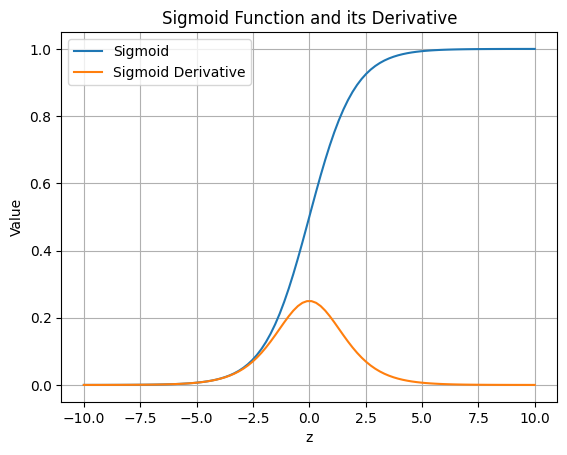

In [23]:
# We will then focus on sigmoid function
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid function and its derivative
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

z = np.linspace(-10, 10, 100)
sig = sigmoid(z)
sig_deriv = sigmoid_derivative(z)

plt.plot(z, sig, label="Sigmoid")
plt.plot(z, sig_deriv, label="Sigmoid Derivative")
plt.title("Sigmoid Function and its Derivative")
plt.xlabel("z")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [24]:
# Simulation with some logits
np.random.seed(42)
logits = np.random.randn(50) * 2
probs = sigmoid(logits)

for z,p in zip(logits, probs):
    print(f"Logit: {z:.2f}, Probability: {p:.4f}")



Logit: 0.99, Probability: 0.7298
Logit: -0.28, Probability: 0.4313
Logit: 1.30, Probability: 0.7851
Logit: 3.05, Probability: 0.9546
Logit: -0.47, Probability: 0.3850
Logit: -0.47, Probability: 0.3850
Logit: 3.16, Probability: 0.9592
Logit: 1.53, Probability: 0.8227
Logit: -0.94, Probability: 0.2811
Logit: 1.09, Probability: 0.7475
Logit: -0.93, Probability: 0.2836
Logit: -0.93, Probability: 0.2826
Logit: 0.48, Probability: 0.6187
Logit: -3.83, Probability: 0.0213
Logit: -3.45, Probability: 0.0308
Logit: -1.12, Probability: 0.2452
Logit: -2.03, Probability: 0.1165
Logit: 0.63, Probability: 0.6521
Logit: -1.82, Probability: 0.1399
Logit: -2.82, Probability: 0.0560
Logit: 2.93, Probability: 0.9494
Logit: -0.45, Probability: 0.3890
Logit: 0.14, Probability: 0.5337
Logit: -2.85, Probability: 0.0547
Logit: -1.09, Probability: 0.2519
Logit: 0.22, Probability: 0.5552
Logit: -2.30, Probability: 0.0910
Logit: 0.75, Probability: 0.6795
Logit: -1.20, Probability: 0.2312
Logit: -0.58, Probability:

Epoch 1/1000, Loss: 0.6931, sigmoid(0): 0.5000
Epoch 101/1000, Loss: 0.3352, sigmoid(0): 0.2004
Epoch 201/1000, Loss: 0.2490, sigmoid(0): 0.0951
Epoch 301/1000, Loss: 0.2056, sigmoid(0): 0.0537
Epoch 401/1000, Loss: 0.1789, sigmoid(0): 0.0338
Epoch 501/1000, Loss: 0.1604, sigmoid(0): 0.0229
Epoch 601/1000, Loss: 0.1466, sigmoid(0): 0.0163
Epoch 701/1000, Loss: 0.1358, sigmoid(0): 0.0120
Epoch 801/1000, Loss: 0.1270, sigmoid(0): 0.0091
Epoch 901/1000, Loss: 0.1196, sigmoid(0): 0.0071
Trained weights: [[2.1875193]]
Trained bias: -5.171182877684308


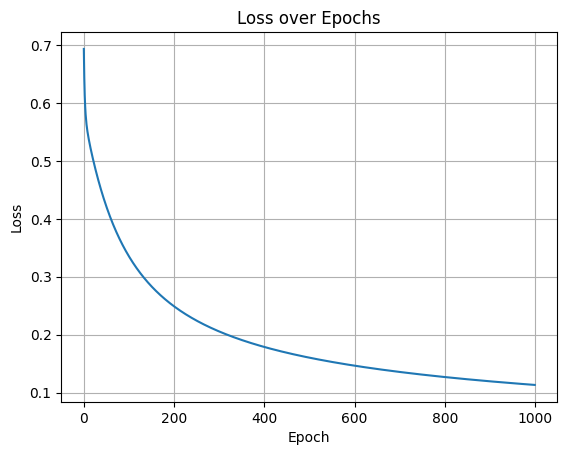

In [26]:
# Now we will make a simple logistic regression from scratch

X = np.array([[0], [1], [2], [3], [4], [5]], dtype=float)
y = np.array([[0], [0], [0], [1], [1], [1]], dtype=float)

w = np.zeros((1,1))
b = 0.0
learning_rate = 0.1
n_epochs = 1000
loss_history = []

for epoch in range(n_epochs):
    z = X @ w + b
    y_pred = sigmoid(z) # Sigmoid activation
    
    loss = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
    loss_history.append(loss)
    dz = y_pred - y
    dw = (X.T @ dz) / X.shape[0]
    db = np.mean(dz)
    
    w -= learning_rate * dw
    b -= learning_rate * db
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}, sigmoid(0): {sigmoid(b):.4f}")

print("Trained weights:", w)
print("Trained bias:", b)

plt.plot(loss_history)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


We will then focus on softmax output unit

In [27]:
import numpy as np
import matplotlib.pyplot as plt

Logits:
 [[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783]]
Softmax Probabilities:
 [[0.37134498 0.19679312 0.4318619 ]
 [0.74345952 0.12826919 0.12827129]
 [0.63573931 0.28231134 0.08194935]
 [0.57785788 0.21131506 0.21082706]
 [0.79632562 0.0922743  0.11140008]]
Cross-Entropy Loss: 1.6195417416240674


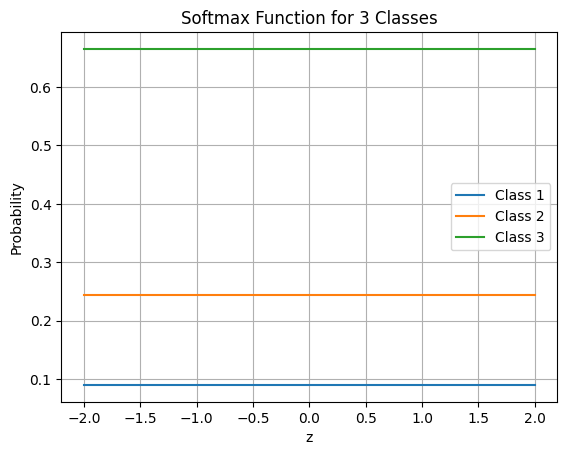

In [29]:
# Define softmax function
def softmax(z):
    # subtract max for numerical stability
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y_true * np.log(y_pred)) / m

np.random.seed(42)
logits = np.random.randn(5, 3)
probs = softmax(logits)

y_true = np.eye(3)[np.random.choice(3, 5)]
loss = cross_entropy_loss(y_true, probs)

print("Logits:\n", logits)
print("Softmax Probabilities:\n", probs)
print("Cross-Entropy Loss:", loss)

#plot the softmax function for 3 classes
z = np.linspace(-2, 2, 100)
Z = np.vstack([z, z + 1, z + 2]).T
softmax_vals = softmax(Z)
plt.plot(z, softmax_vals[:, 0], label="Class 1")
plt.plot(z, softmax_vals[:, 1], label="Class 2")
plt.plot(z, softmax_vals[:, 2], label="Class 3")
plt.title("Softmax Function for 3 Classes")
plt.xlabel("z")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()